# Exploration of the Heart Disease Data Set
#### Group Project Proposal 005-6

## Introduction

The dataset describes the age, sex, and other medical information about the patients that will give information on whether the patient might have heart disease or not. The last attribute gives a diagnosis of heart disease for that patient, with a value of 0 being a <50% diameter of the vessel narrowing, or a value of 1 being a >50% diameter of the vessel narrowing. This attribute uses angiographys as a way to predict and diagnose heart disease. 

The question we will try to answer is whether a patient will be diagnosed with heart disease. We have a number of predictors and we will use the technique of backward selection to narrow down our predictors to the few attributes that allow us to predict this most accurately.

We will be using the Heart Disease Data set. This database describes 76 attributes but all experiments that have been published use only 14 as a reference. The “goal” field describes the presence of heart disease in the patient. The values of this field range from 0 to 4 with 0 being no presence and 1-4 a range of presence. The data set has numerous attributes related to a full medical history of the patient. These attributes include various types of information related to heart disease like chest pain, years as a smoker, family history of heart disease and other related diseases, blood sugar levels, exercise levels, and anginas (chest pain due to reduced blood flow, symptom of coronary artery disease). An angina is a very clear symptom of heart disease and has various types of anginas (as categorized by the data set with values 1, 2, 3, 4). A typical angina (value = 1) usually lasts for a few minutes and over the counter medicine can make it go away. An atypical angina (value = 2) can get worse over time and may indicate that the person is having a heart attack. A nonanginal pain (value = 3) usually results in pain similar to a normal angina however is due to different causes. Lastly, an asymptomatic angina is when there is an angina occurring, however usually little to no pain is experienced. 

## Preliminary exploratory data analysis

In [10]:
library(tidyverse)
library(tidymodels)
library(repr)
library(MASS)
options(repr.matrix.max.rows = 6)

### Read the dataset, clean and wrangle the data into a tidy format.

Download the dataset from the url and store it into a local `csv` file.

In [11]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

download.file(url, destfile = "data/processed.cleveland.data")

Read the file into `heart_disease_original`. A

In [12]:
heart_disease_original <- read_csv("data/processed.cleveland.data", 
                                   # add column names
                                   col_names = c("age",
                                                 "sex",
                                                 "cp", 
                                                 "trestbps", 
                                                 "chol", 
                                                 "fbs", 
                                                 "restecg", 
                                                 "thalach", 
                                                 "exang", 
                                                 "oldpeak", 
                                                 "slope", 
                                                 "ca", 
                                                 "thal", 
                                                 "num"))

head(heart_disease_original, 10)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0,2
53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,1


Wrangle the data set by changing the types, filtering essentially NA values and changing values to be easily interpretable.

In [13]:
heart_disease <- heart_disease_original |> 

                    # remove all rows that contain a question
                    # mark (esentially NA values) to supress
                    # warnings from R
                    filter(thal != "?", ca != "?") |>

                    # change columns ca and thal to be numeric
                    # to allow for tidymodels to work properly
                    mutate(ca = as.numeric(ca),
                          thal = as.numeric(thal),
                          num = as_factor(num)) |>

                    # remove rows with NA values
                    na.omit()     

head(heart_disease, 10)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
63,1,4,130,254,0,2,147,0,1.4,2,1,7,2
53,1,4,140,203,1,2,155,1,3.1,3,0,7,1


Let's check the distribution for our factor variable `num`. 

In [14]:
heart_disease |> 
   group_by(num) |> 
   summarize(count = n())

num,count
<fct>,<int>
0,160
1,54
2,35
3,35
4,13


It looks like there is an uneven proportion of data where num = 1, 2, 3 or 4. Therefore, since a `num` value of 0 just represents no heart disease present and a `num` value of 1-4 means varying levels of heart disease, we can convert this dataset to just give us a binary value of 0 or 1. If it's 0, then we know there is no heart disease present in the patient. If it's 1, then we can do further testing to determine how much heart disease is present.

Modify the num attribute so that it only contains 0 (< 50% diameter narrowing) and 1 (> 50% diameter narrowing).

In [26]:
# if num is equal to 2, 3, or 4, change it to 1
heart_disease$num[heart_disease$num == 2 | heart_disease$num == 3 | heart_disease$num == 4] = 1

head(heart_disease, 10)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
63,1,4,130,254,0,2,147,0,1.4,2,1,7,1
53,1,4,140,203,1,2,155,1,3.1,3,0,7,1


### Split the dataset into training set and testing set.

In [27]:
set.seed(2000)

heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = num)
heart_disease_training <- training(heart_disease_split)
heart_disease_testing <- testing(heart_disease_split)

age: age in years

sex: sex (1 = male; 0 = female)

cp: chest pain type

* Value 1: typical angina

* Value 2: atypical angina

* Value 3: non-anginal pain

* Value 4: asymptomatic

trestbps: resting blood pressure (in mm Hg on admission to the hospital)

chol: serum cholestoral in mg/dl

fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)

restecg: resting electrocardiographic results

thalach: maximum heart rate achieved

exang: exercise induced angina (1 = yes; 0 = no)

oldpeak = ST depression induced by exercise relative to rest

slope: the slope of the peak exercise ST segment

* Value 1: upsloping

* Value 2: flat

* Value 3: downsloping

ca: number of major vessels (0-3) colored by flourosopy

thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

num: diagnosis of heart disease (angiographic disease status)

* Value 0: < 50% diameter narrowing

* Value 1: > 50% diameter narrowing


Section 6.8.3 of the data science textbook briefly mentions the method of forward selection in R. However, the method it shows is far too manual. The more manual we make our program, the more prone it is to errors. Therefore, we will be using the `MASS` library to import a few functions which allow us to do the same thing.

We have 14 predictors and, given our limited biology knowledge, we can't seem to easily dismiss any predictors that would have no correlation with the presence of heart disease. Therefore, instead of forward selection, we will use backward selection to remove one predictor at a time. Then, we will check if the `AIC` of the new model goes down. We will remove the predictor which lowers the `AIC` the most until we get to a point where removing predictors increases `AIC`. 

In [35]:
heart_disease_training_aic <- heart_disease_training |>
    mutate(ca = as.numeric(ca),
           thal = as.numeric(thal),
           num = as.numeric(num))

In [36]:
null <- lm(num ~ 1, data = heart_disease_training_aic) # 1 here means the intercept 
full <- lm(num ~ ., data = heart_disease_training_aic)
 
(stepAIC(full, scope=list(lower=null, upper=full), 
        data=heart_disease_training_aic, direction='backward'))

Start:  AIC=-446.84
num ~ age + sex + cp + trestbps + chol + fbs + restecg + thalach + 
    exang + oldpeak + slope + ca + thal

           Df Sum of Sq    RSS     AIC
- age       1   0.00258 26.151 -448.81
- chol      1   0.04695 26.195 -448.44
- trestbps  1   0.11120 26.259 -447.89
- restecg   1   0.12348 26.271 -447.79
- fbs       1   0.16676 26.315 -447.43
- thalach   1   0.21345 26.361 -447.03
<none>                  26.148 -446.84
- slope     1   0.23962 26.388 -446.81
- oldpeak   1   0.39217 26.540 -445.53
- exang     1   0.87443 27.023 -441.53
- thal      1   0.99885 27.147 -440.51
- sex       1   1.07920 27.227 -439.86
- cp        1   1.33336 27.481 -437.80
- ca        1   2.75647 28.904 -426.59

Step:  AIC=-448.81
num ~ sex + cp + trestbps + chol + fbs + restecg + thalach + 
    exang + oldpeak + slope + ca + thal

           Df Sum of Sq    RSS     AIC
- chol      1   0.04468 26.195 -450.44
- trestbps  1   0.10873 26.259 -449.89
- restecg   1   0.12235 26.273 -449.78
- fbs  


Call:
lm(formula = num ~ sex + cp + exang + oldpeak + slope + ca + 
    thal, data = heart_disease_training_aic)

Coefficients:
(Intercept)          sex           cp        exang      oldpeak        slope  
    0.42420      0.15331      0.10901      0.18233      0.05780      0.08773  
         ca         thal  
    0.14333      0.04742  


### Using only training data, summarize the data in one table.

Count the number of observations for each `thal` value.

In [49]:
# heart_disease_training <- heart_disease_training |>
#     )

heart_disease_recipe <- recipe(num ~ sex + cp + exang + oldpeak + slope + ca + thal,
                               data = heart_disease_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())


In [44]:

# cancer_vfold <- vfold_cv(heart_disease_training, v = 5, strata = num)


# knn_spec <- nearest_neighbor(weight_func = "rectangular", 
#                              neighbors = tune()) |>
#   set_engine("kknn") |>
#   set_mode("classification")

# k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# knn_results <- workflow() |>
#   add_recipe(heart_disease_recipe) |>
#   add_model(knn_spec) |>
#   tune_grid(resamples = cancer_vfold, grid = k_vals) |>
#   collect_metrics() 

# accuracies <- knn_results |>
#   filter(.metric == "accuracy") |>
#   arrange(desc(mean))

# accuracies

In [45]:
# accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
#   geom_point() +
#   geom_line() +
#   labs(x = "Neighbors", y = "Accuracy Estimate") + 
#   theme(text = element_text(size = 12))

# accuracy_vs_k

In [50]:
cancer_vfold <- vfold_cv(heart_disease_training, v = 5, strata = num)


knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 26) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(heart_disease_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_disease_training)



#   fit_resamples(resamples = cancer_vfold) |>
#   collect_metrics() 

# accuracies <- knn_results |>
#   filter(.metric == "accuracy") |>
#   arrange(desc(mean))

# accuracies

In [51]:
(cancer_test_predictions <- predict(knn_fit, heart_disease_testing) |>
  bind_cols(heart_disease_testing))

cancer_test_predictions |>
  metrics(truth = num, estimate = .pred_class) |>
  filter(.metric == "accuracy")

confusion <- cancer_test_predictions |>
             conf_mat(truth = num, estimate = .pred_class)
confusion

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
1,53,1,4,140,203,1,2,155,1,3.1,3,0,7,1
1,56,1,3,130,256,1,2,142,1,0.6,2,1,6,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,39,0,3,138,220,0,0,152,0,0.0,2,0,3,0
1,63,1,4,140,187,0,2,144,1,4.0,1,2,7,1
0,45,1,1,110,264,0,0,132,0,1.2,2,0,7,1


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8266667


          Truth
Prediction  0  1  2  3  4
         0 36  9  0  0  0
         1  4 26  0  0  0
         2  0  0  0  0  0
         3  0  0  0  0  0
         4  0  0  0  0  0

In [52]:
heart_disease_aggregated_by_thal <- heart_disease_training |> 
   group_by(num) |> 
   summarize(count = n()) |>
   mutate(percent = 100*count/(120+102))

heart_disease_aggregated_by_thal

heart_disease_testing |> 
   group_by(num) |> 
   summarize(count = n()) |>
   mutate(percent = 100*count/(40+35))

num,count,percent
<fct>,<int>,<dbl>
0,120,54.05405
1,102,45.94595


num,count,percent
<fct>,<int>,<dbl>
0,40,53.33333
1,35,46.66667


### Using only training data, visualize the data with a plot.

Plot the data with age, maximum heart rate achieved and sex.

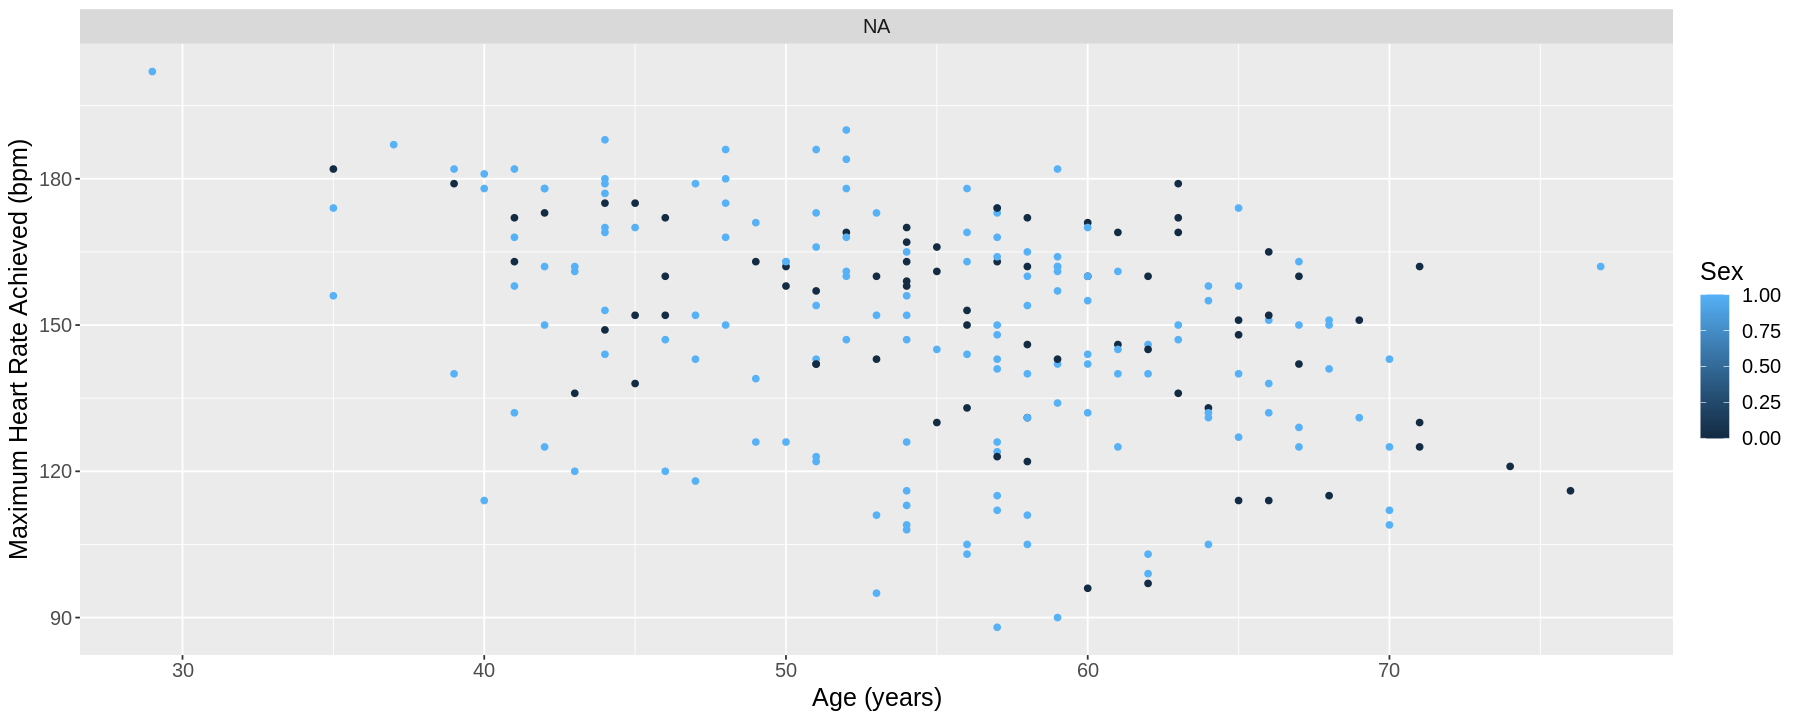

In [34]:
options(repr.plot.width = 15, repr.plot.height = 6)

heart_disease_plot <- heart_disease_training |>
    ggplot(aes(x = age, y = thalach)) + 
    geom_point(aes(colour = sex)) + 
    labs(x = "Age (years)", y = "Maximum Heart Rate Achieved (bpm)", color = "Sex") +
    facet_wrap(facets = vars(factor(sex, levels = c("male","female")))) +
    theme(text = element_text(size = 15))

heart_disease_plot

## Methods

- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?

We will try and use k-nn regression using the indicators of age and maximum heart rate achieved with `num` to see if we can predict the presence of heart disease using the indicators. We will also compare the results between the two sexes to see if these indicators work well with a certain sex or not.

- Describe at least one way that you will visualize the results

We will use scatter plots to visualize our result. We would also use a heat map to visualize our confusion matrices for different values of $K$. 

## Expected outcomes and significance

- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?

  We expect to find information pointing towards the best range of conditions individuals should be in to avoid heart diseases. Our findings will show how likely a patient will be diagnosed with a heart disease based on the variables presented. These findings could be used to convey health care information towards the general public. Health care professionals can also use these findings to provide better care and diagnosis. Thereby improving the quality of life for patients of all different backgrounds. These findings could lead to questions about the best way to take care of your heart and future medical innovations. 


# References

https://advstats.psychstat.org/book/mregression/selection.php